In [1]:
import sys
sys.path.append('../lib/')
from BlackbodyFunctions import *
from scipy.signal import get_window

0.11400392702867283595
0.1140039270276700888
0.11400392700764653655


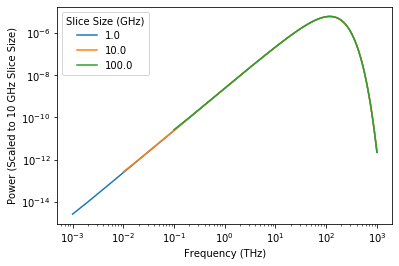

In [2]:
def makePlot(slice_size,useTrap=False):
    freqs = np.arange(slice_size,1e15,slice_size)
    w = blackbodyWeights(freqs,slice_size,useTrap=useTrap)
    plot(freqs*1e-12,w*(1e10/slice_size),label=slice_size*1e-9)
    print(np.sum(w))
    yscale('log')
    xscale('log')
    
for slice_size in [1e9,1e10,1e11]:
    makePlot(slice_size,useTrap=True)
legend(title='Slice Size (GHz)',loc='upper left')
xlabel('Frequency (THz)')
ylabel('Power (Scaled to 10 GHz Slice Size)')
show()

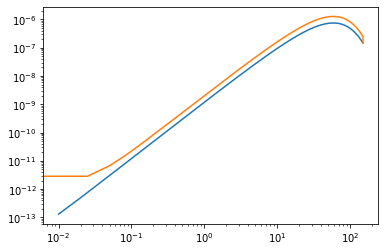

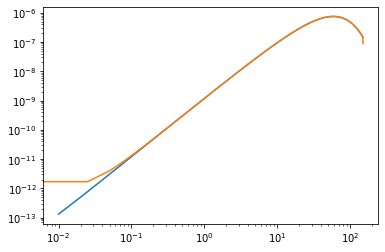

In [43]:
p_output = p_nofilter.copy() #should be in units of W^2 micron (dP^2/dk)

dfdk = c_micron_per_second

p_output_hz = p_output/dfdk # now should be dP^2/df

f_output_hz = f_nofilter*dfdk # convert k to f
df = f_output_hz[1]-f_output_hz[0]

loglog(frequencies, weights_nofilter)
loglog(f_output_hz*1e-12,np.sqrt(p_output_hz*df))
#yscale('linear')
show()

loglog(frequencies, weights_nofilter)
loglog(f_output_hz*1e-12,np.sqrt(p_output_hz*df)/1.7)
#yscale('linear')

In [26]:
f_output_hz[2]-f_output_hz[1]

25000000000.0

In [39]:
sqrt(pi)

1.7724538509055159

50000.0
0.0 1500.0
10.0
25.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

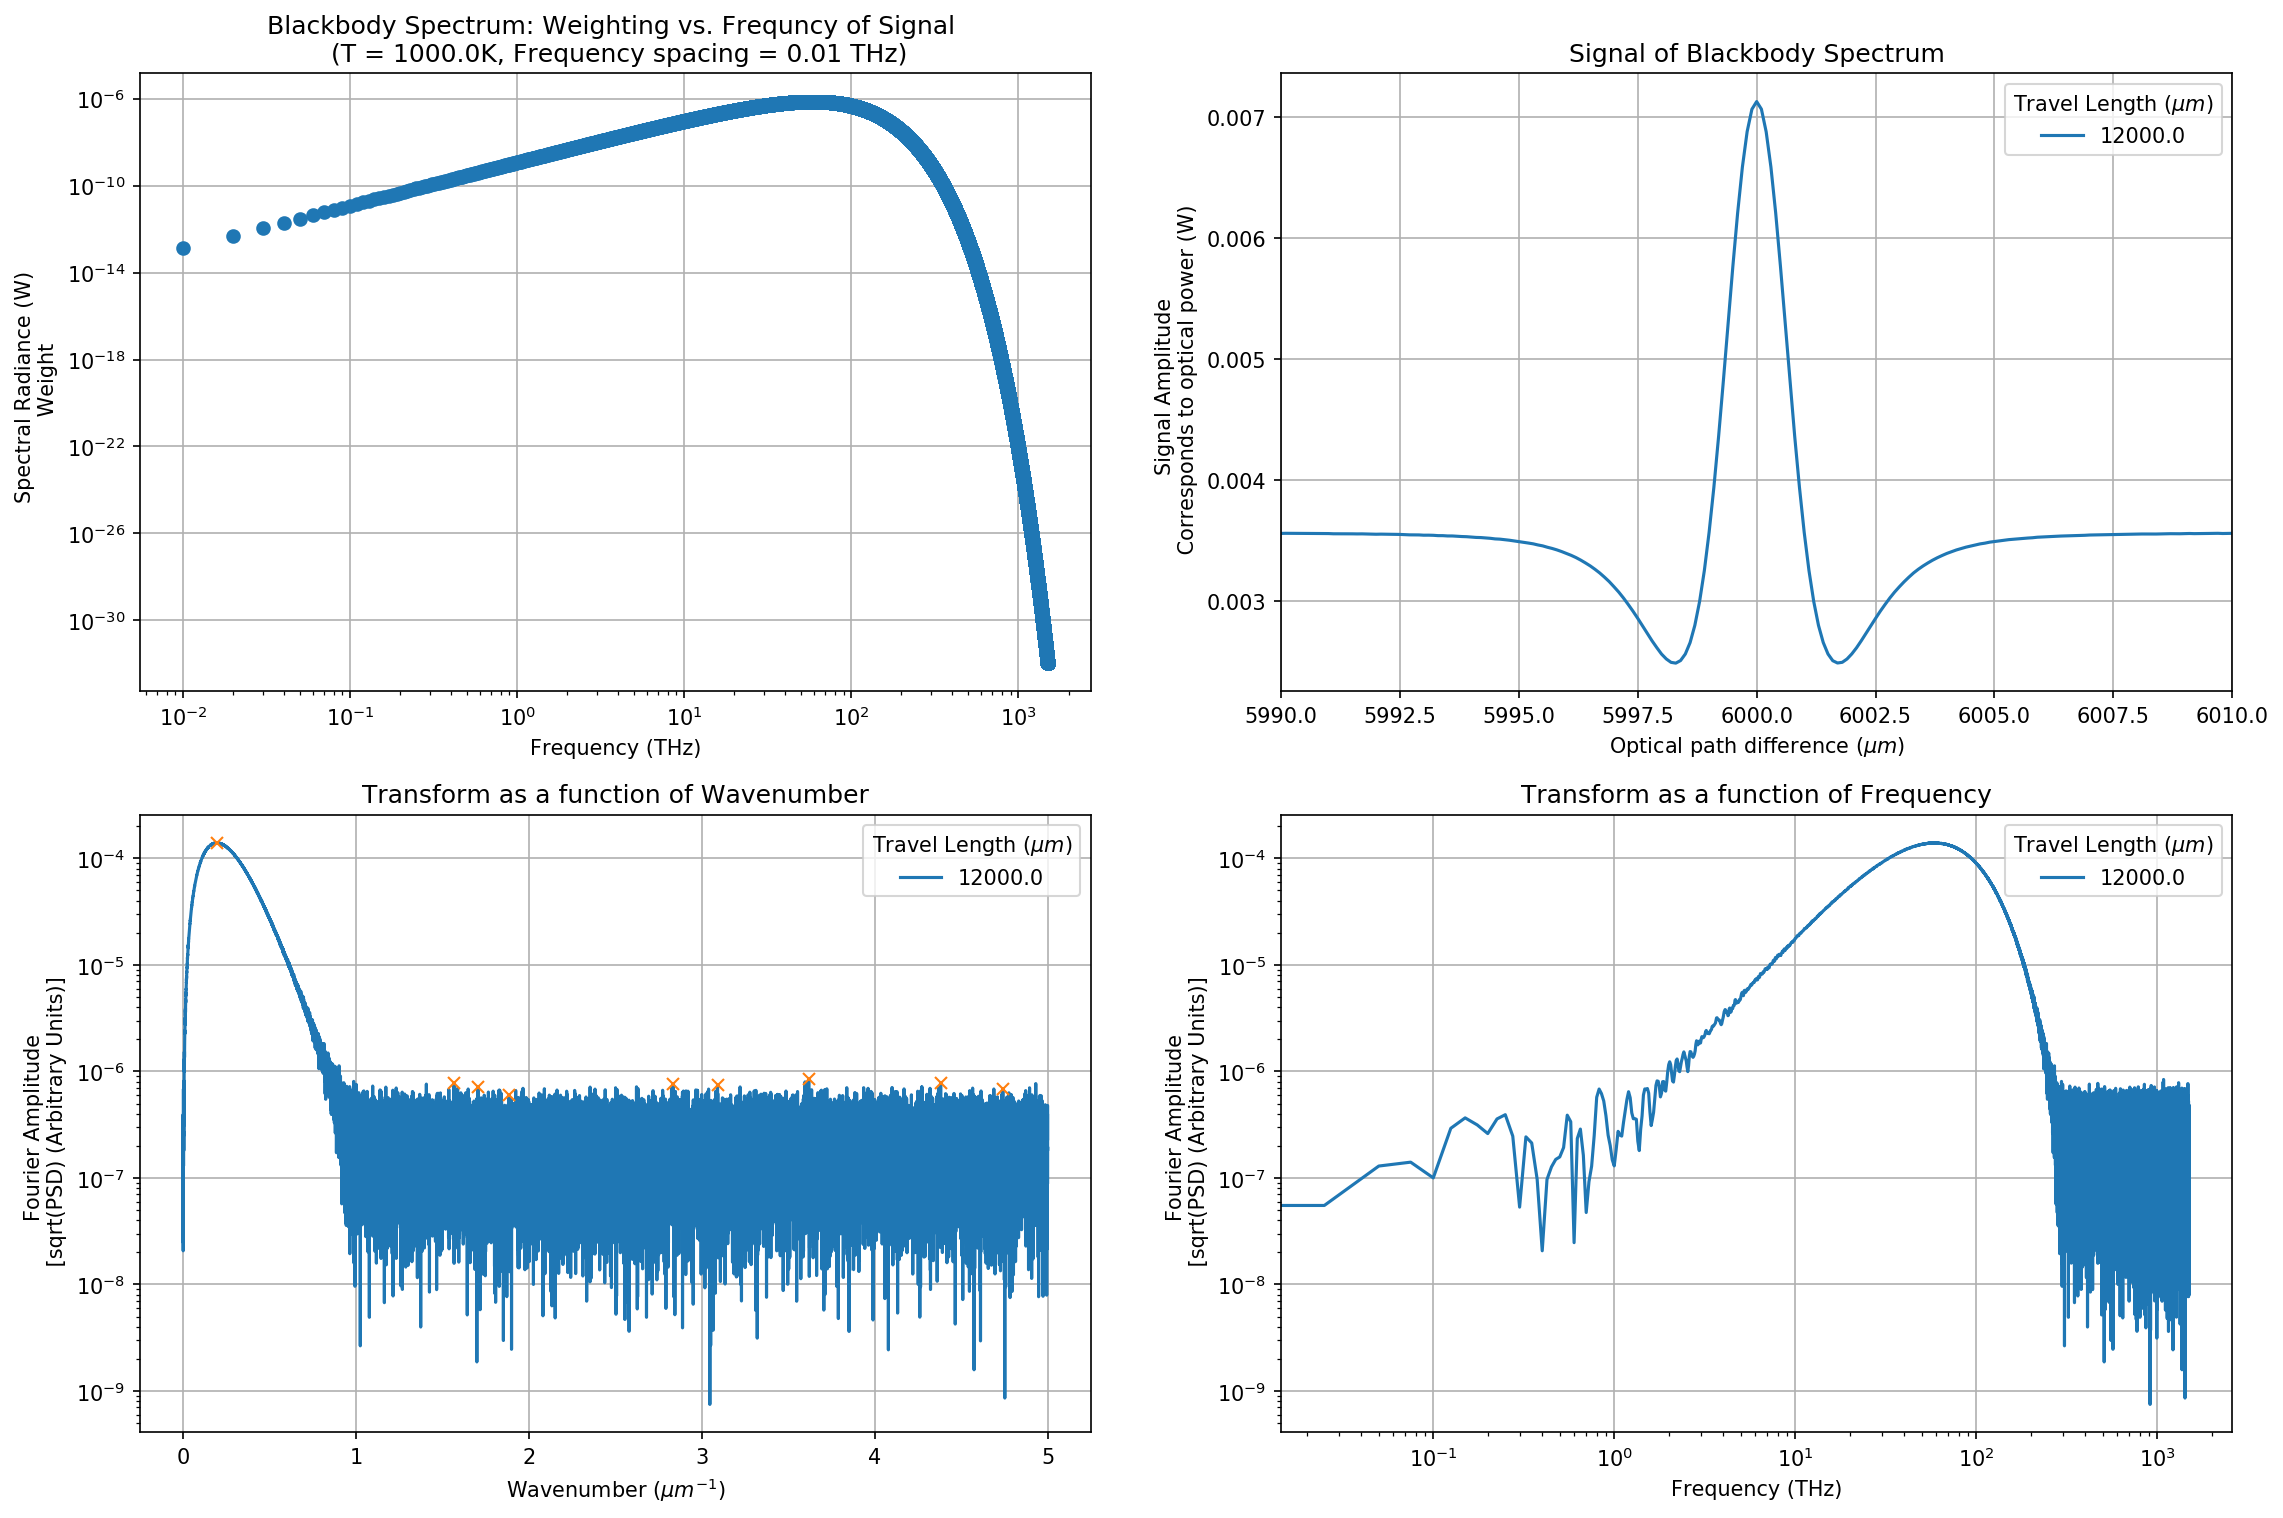

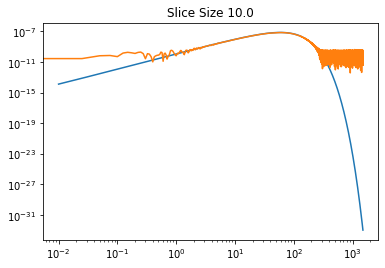

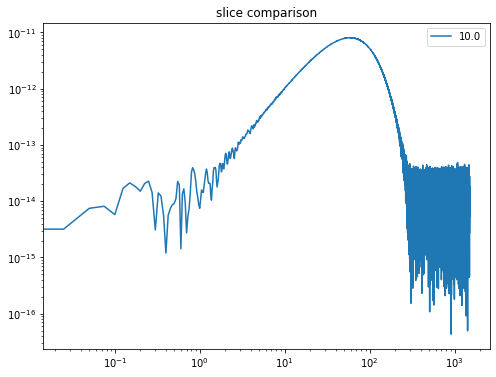

In [104]:
arm_length_1 = 15.0 #cm
arm_length_2 = 10.0 #cm
cm_to_micron = 1e4
dx = abs(arm_length_1-arm_length_2)*cm_to_micron
print(dx)
dx = -6e3

Temp = 1e3 #K

adjustment = 1e-7

dt = 0.1 #micron, step size
fs = 1.0/dt #micron^-1, inv. step size (multiply by h gives energy resolution)
T = 1.2e4 #micron, total travel length
sigma = 2e-6 #noise offset intensity
peaks = []
weights_nofilter = []
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
peak_thershold = 1e-6 #increase this as noise increases, to ensure we are not accidnetally claiming the noise as a peak

slice_sizes = [0.01]
for i in range(0,len(slice_sizes)):
    fig = plt.figure(figsize=(18, 12), dpi=150)  

    #for blackbody spectrum, decide frequeny range and number of frequency slices 
    min_frequency = 0.01 #THz
    max_frequency = 1500 #THz
    frequency_slice_size = slice_sizes[i] #micron
    frequencies = arange(min_frequency, max_frequency, frequency_slice_size) #still in THz

    weights_nofilter = blackbodyWeights(frequencies*1e12,frequency_slice_size*1e12,useTrap=True,Temp=Temp)

    #This section of code creates the signal
    #for nu in frequencies: #(THz)
    #  weights_nofilter.append(power_intensity(nu, frequency_slice_size)) # for blackbody, this is the blackbody intensity in W
    plt.subplot(2, 2, 1)
    plt.plot(frequencies, weights_nofilter , 'o')
    xscale('log')

    x=np.arange(0,T,dt)
    y_phaseNoise = np.zeros_like(x)

    for nu in range(len(frequencies)):
        k = frequencies[nu]/(Hz_to_THz*c_micron_per_second) #get wavenumber
        phase = 2.0*pi*dx*k #phase offset depends on wavenumber
        y_phaseNoise += weights_nofilter[nu]*0.5*(np.cos(2.0*pi*k*x + phase)+ 1.0)
    y = y_phaseNoise + np.random.rand(len(y_phaseNoise))*sigma #create the input signal


    plt.subplot(2, 2, 2)
    plt.plot(x,y,label= T)

    plt.subplot(2, 2, 3)
    f_nofilter,p_nofilter = psd(y,fs=fs,window=get_window('parzen',len(y))) #wavenumber, spectrum
    plt.semilogy(f_nofilter, np.sqrt(p_nofilter), label=T)
    peaks_index, _ = find_peaks(np.log10(np.sqrt(p_nofilter)), prominence=(2.3))
    plt.plot(f_nofilter[peaks_index], np.sqrt(p_nofilter[peaks_index]), "x")
    peaks.append(f_nofilter[peaks_index])

    p_adjusted_nofilter = np.sqrt(p_nofilter) - adjustment
    for ps in range(len(p_adjusted_nofilter)):
        if p_adjusted_nofilter[ps] < 0:
            p_adjusted_nofilter[ps] = 0

    print(min(f_nofilter)*c_micron_per_second*Hz_to_THz,max(f_nofilter)*c_micron_per_second*Hz_to_THz)
    
    plt.subplot(2, 2, 4)
    plt.semilogy(f_nofilter*c_micron_per_second*Hz_to_THz, np.sqrt(p_nofilter),label=T)

    #plot details for blackbody spectrum plot
    plt.subplot(2, 2, 1)
    plt.grid(True)
    plt.yscale('log')
    title = "Blackbody Spectrum: Weighting vs. Frequncy of Signal \n (T = " + str(Temp) + "K, Frequency spacing = "+ str(round(frequency_slice_size,2)) + " THz)"
    plt.title(title)
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Spectral Radiance (W) \n Weight")

    #plot details for signal plot
    plt.subplot(2, 2, 2)
    plt.grid(True)
    plt.title("Signal of Blackbody Spectrum")
    plt.legend(title="Travel Length ($\mu m$)")
    plt.legend(title="Travel Length ($\mu m$)")
    plt.xlabel("Optical path difference ($\mu m$)")
    plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")
    xlim(5990,6010)

    #plot details for fourier transform plot
    plt.subplot(2, 2, 3)
    plt.title("Transform as a function of Wavenumber")
    plt.grid(True)
    plt.legend(title="Travel Length ($\mu m$)")
    plt.xlabel('Wavenumber ($\mu m ^{-1}$)')
    plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")

    #plot details for fourier transform plot in terms of frequency rather than wavenumber
    plt.subplot(2, 2, 4)
    plt.title("Transform as a function of Frequency")
    plt.xscale('log')
    plt.grid(True)
    plt.legend(title="Travel Length ($\mu m$)")
    plt.xlabel('Frequency (THz)')
    plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")
    #plt.show()

    # print("For total travel distance ", Tlist[0], "µm the peaks occur at frequencies:", peaks[0]*c_micron_per_second*Hz_to_THz , "THz")
    # print("There are ", len(peaks[0]), " measured peaks")

    p_output = p_nofilter.copy() #should be in units of W^2 micron (dP^2/dk)

    dfdk = c_micron_per_second

    p_output_hz = p_output/dfdk # now should be dP^2/df

    f_output_hz = f_nofilter*dfdk # convert k to f
    df = frequency_slice_size/Hz_to_THz
    df_out = f_output_hz[1] - f_output_hz[0]
    print(df*1e-9)
    print(df_out*1e-9)
    
    input_PSD = weights_nofilter/df

    figure()
    loglog(frequencies, weights_nofilter/df*1e9)
    loglog(f_output_hz*1e-12,np.sqrt(p_output_hz*2/df_out)*1e9)
    plt.title('Slice Size '+str(frequency_slice_size*1e3))
    
    figure(100,figsize=(8,6))
    loglog(f_output_hz*1e-12,np.sqrt(p_output_hz),label=str(frequency_slice_size*1e3))
    plt.title('slice comparison')
    legend()

10.0
25.0


Text(0, 0.5, 'Power Density (W/THz)')

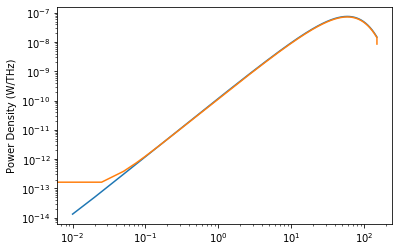

In [99]:
p_output = p_nofilter.copy() #should be in units of W^2 micron (dP^2/dk)

dfdk = c_micron_per_second

p_output_hz = p_output/dfdk # now should be dP^2/df

f_output_hz = f_nofilter*dfdk # convert k to f
df = (frequencies[1]-frequencies[0])/Hz_to_THz
df_out = f_output_hz[1] - f_output_hz[0]
print(df*1e-9)
print(df_out*1e-9)

figure()
loglog(frequencies, weights_nofilter/df*1e9)
loglog(f_output_hz*1e-12,np.sqrt(p_output_hz*df_out)/df_out*1e9*sqrt(2))
ylabel('Power Density (W/THz)')